Esta notebook contiene bloques de código útiles para el juego TacTix

In [1]:
from tactix_env import TacTixEnv
from trainer_agent import TrainerAgent
from random_agent import RandomTacTixAgent
from minimax_agent import MinimaxAgent
import wandb
from expectimax_agent import ExpectimaxAgent
from play import play_vs_other_agent, run_multiple_games, plot_results

In [2]:
env = TacTixEnv(board_size=6, misere=False)
obs = env.reset()
env.render()

# Example action: take from row 1, positions 0 to 2
obs, reward, done, _ = env.step([1, 0, 2, 1])
env.render()

O O O O O O
O O O O O O
O O O O O O
O O O O O O
O O O O O O
O O O O O O
Player 1's turn (Normal rules)

O O O O O O
. . . O O O
O O O O O O
O O O O O O
O O O O O O
O O O O O O
Player 2's turn (Normal rules)



In [3]:
env.action_space.sample()

array([2, 5, 4, 1])

In [4]:
env.observation_space.sample()

{'board': array([[1, 0, 0, 1, 0, 1],
        [0, 1, 0, 0, 1, 0],
        [0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 0]], dtype=int32),
 'current_player': np.int64(0)}

Random Agents

In [5]:
import importlib
import minimax_agent
import numpy as np  # Make sure numpy is imported
importlib.reload(minimax_agent)
from minimax_agent import MinimaxAgent

random_agent_1 = RandomTacTixAgent(env)
random_agent_2 = RandomTacTixAgent(env)
minimax_agent = MinimaxAgent(env)

play_vs_other_agent(env, random_agent_1, minimax_agent, render=False)

Agent 2 wins!


2

Multiple Games

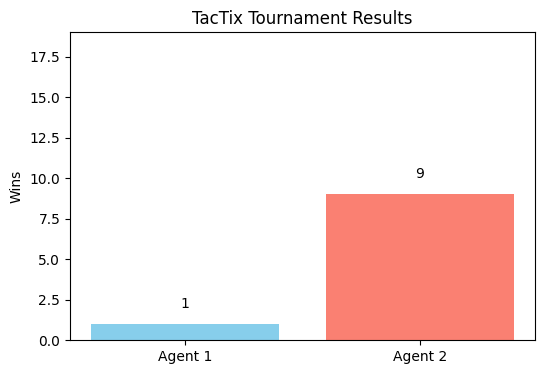

In [6]:
results = run_multiple_games(env, random_agent_1, minimax_agent, num_games=10)
plot_results(results)

In [7]:
import importlib
import expectimax_agent
import numpy as np
importlib.reload(expectimax_agent)
from expectimax_agent import ExpectimaxAgent

# Crear un agente expectimax
expectimax_agent = ExpectimaxAgent(env, depth=2)

# Jugar contra un agente aleatorio
print("Expectimax vs Random:")
play_vs_other_agent(env, expectimax_agent, random_agent_1, render=False)

Expectimax vs Random:
Agent 2 wins!


2

## Play Minimax vs Trainer

In [8]:
# Minimax. Run a series of games with different difficulties for the TrainerAgent
difficulties = [i / 10 for i in range(11)]
results_summary_minimax = []

total_agent1_wins_minimax = 0
total_agent2_wins_minimax = 0
total_agent2_losses_minimax = 0

wandb.init(project="tactix-experiments", name="trainer_vs_minimax")

for d in difficulties:
    agent1 = TrainerAgent(env, difficulty=d)
    agent2 = MinimaxAgent(env)
    
    results = run_multiple_games(env, agent1, agent2, num_games=20)
    results_summary_minimax.append((d, results["agent1_wins"], results["agent2_wins"]))
    
    total_agent1_wins_minimax += results["agent1_wins"]
    total_agent2_wins_minimax += results["agent2_wins"]
    total_agent2_losses_minimax += results["agent1_wins"]
    
    wandb.log({
        "difficulty": d,
        "agent1_wins": results["agent1_wins"],
        "agent2_wins": results["agent2_wins"]
    })
    
table= wandb.Table(data =[
    ["Agent1", total_agent1_wins_minimax],
    ["Agent2", total_agent2_wins_minimax]
], columns=["Agent", "Wins"])


wandb.log({"total_wins_bar_chat": wandb.plot.bar(table, "Agent", "Wins", title="Total Wins by Agent")})

print(f"Total Agent 2 Wins: {total_agent2_wins_minimax}")
print(f"Total Agent 2 Losses: {total_agent2_losses_minimax}")

wandb.finish()
    
    

wandb: Currently logged in as: agustinvarela2606 (artificial-inteligence-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Total Agent 2 Wins: 211
Total Agent 2 Losses: 9


agent1_wins,█▁▁▁▁▅███▁▁
agent2_wins,▁████▅▁▁▁██
difficulty,▁▂▂▃▄▅▅▆▇▇█
agent1_wins,0
agent2_wins,20
difficulty,1


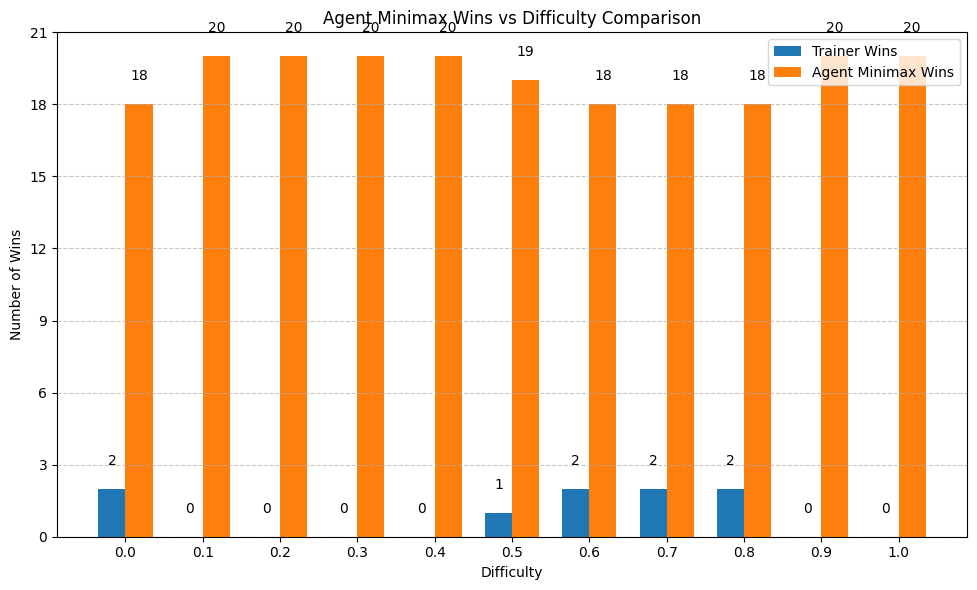

In [9]:
# Minimax. Plot results with double bar chart
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator  # Importar MaxNLocator para ticks de valores enteros

probs = [x[0] for x in results_summary_minimax]
agent1_wins_minimax = [x[1] for x in results_summary_minimax]
agent2_wins_minimax = [x[2] for x in results_summary_minimax]

# Set width for bars
bar_width = 0.35
index = np.arange(len(probs))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = plt.bar(index - bar_width/2, agent1_wins_minimax, bar_width, label='Trainer Wins')
bar2 = plt.bar(index + bar_width/2, agent2_wins_minimax, bar_width, label='Agent Minimax Wins')

# Add values on top of the bars
for i, v in enumerate(agent1_wins_minimax):
    plt.text(i - bar_width/2, v + 1, str(v), ha='center')

for i, v in enumerate(agent2_wins_minimax):
    plt.text(i + bar_width/2, v + 1, str(v), ha='center')

# Configure the chart
plt.xlabel('Difficulty')
plt.ylabel('Number of Wins')
plt.title('Agent Minimax Wins vs Difficulty Comparison')
plt.xticks(index, [f"{p:.1f}" for p in probs])
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Configurar el eje Y para que solo muestre valores enteros
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

## Guardado del agente en formato .pkl

In [10]:
import pickle

with open("minimax_agent.pkl", "wb") as f:
    pickle.dump(agent2, f)

## Play Expectimax vs trainer

In [11]:
# ExpectiMax. Run a series of games with different difficulties for the TrainerAgent 
difficulties = [i / 10 for i in range(11)]
results_summary_expectimax = []

total_agent1_wins_expectimax=0
total_agent2_wins_expectimax=0

wandb.init(project="tactix-experiments", name="trainer_vs_expectiMax")

for d in difficulties:
    agent1 = TrainerAgent(env, difficulty=d)
    agent2 = ExpectimaxAgent(env)
    
    results = run_multiple_games(env, agent1, agent2, num_games=20)
    results_summary_expectimax.append((d, results["agent1_wins"], results["agent2_wins"]))
    
    total_agent1_wins_expectimax += results["agent1_wins"]
    total_agent2_wins_expectimax += results["agent2_wins"]
    
    wandb.log({
        "difficulty": d,
        "agent1_wins": results["agent1_wins"],
        "agent2_wins": results["agent2_wins"]
    })
    
table= wandb.Table(data =[
    ["Agent1", total_agent1_wins_expectimax],
    ["Agent2", total_agent2_wins_expectimax]
], columns=["Agent", "Wins"])


wandb.log({"total_wins_bar_chat": wandb.plot.bar(table, "Agent", "Wins", title="Total Wins by Agent")})

wandb.finish()
    
    

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


agent1_wins,▁▁▁▂▂▁▂▃▃▆█
agent2_wins,███▇▇█▇▆▆▃▁
difficulty,▁▂▂▃▄▅▅▆▇▇█
agent1_wins,20
agent2_wins,0
difficulty,1


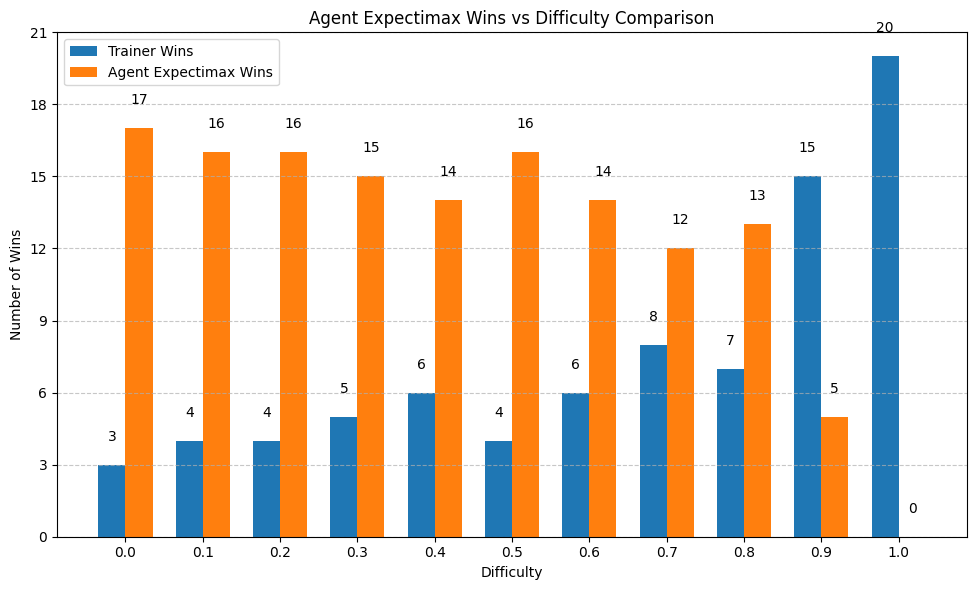

In [12]:
# ExpectiMax. Plot results with double bar chart
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator  # Importar MaxNLocator para ticks de valores enteros

probs = [x[0] for x in results_summary_expectimax]
agent1_wins_expectimax = [x[1] for x in results_summary_expectimax]
agent2_wins_expectimax = [x[2] for x in results_summary_expectimax]

# Set width for bars
bar_width = 0.35
index = np.arange(len(probs))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = plt.bar(index - bar_width/2, agent1_wins_expectimax, bar_width, label='Trainer Wins')
bar2 = plt.bar(index + bar_width/2, agent2_wins_expectimax, bar_width, label='Agent Expectimax Wins')

# Add values on top of the bars
for i, v in enumerate(agent1_wins_expectimax):
    plt.text(i - bar_width/2, v + 1, str(v), ha='center')

for i, v in enumerate(agent2_wins_expectimax):
    plt.text(i + bar_width/2, v + 1, str(v), ha='center')

# Configure the chart
plt.xlabel('Difficulty')
plt.ylabel('Number of Wins')
plt.title('Agent Expectimax Wins vs Difficulty Comparison')
plt.xticks(index, [f"{p:.1f}" for p in probs])
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Configurar el eje Y para que solo muestre valores enteros
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

# Cargado de agente en formato .pkl 

In [ ]:
with open("minimax_agent.pkl", "rb") as f:
    loaded_agent = pickle.load(f)

: 